## Load results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyabc

h = pyabc.History("sqlite:///tumor2d_stoch_acc_v5.db")
h_incorrect = pyabc.History("sqlite:///tumor2d_incorrect_v5_v2.db")
h_noisymodel = pyabc.History("sqlite:///tumor2d_noisymodel_v5.db")
h_higherc = pyabc.History("sqlite:///tumor2d_stoch_acc_v5_higherc.db")
h_incorrect_l2 = pyabc.History("sqlite:///tumor2d_incorrect_l2_v5.db")

limits = dict(log_division_rate=(-3, -1),
              log_division_depth=(1, 3),
              log_initial_spheroid_radius=(0, 1.2),
              log_initial_quiescent_cell_fraction=(-5, 0),
              log_ecm_production_rate=(-5, 0),
              log_ecm_degradation_rate=(-5, 0),
              log_ecm_division_threshold=(-5, 0))

refval = dict(log_division_rate=4.17e-2,
              log_initial_spheroid_radius=1.2e1,
              log_initial_quiescent_cell_fraction=7.5e-1,
              log_division_depth=100,
              log_ecm_production_rate=5e-3,
              log_ecm_degradation_rate=8e-4,
              log_ecm_division_threshold=1e-2,)
for key, val in refval.items():
    refval[key] = np.log10(val)
    
print(h.max_t, h_incorrect.max_t, h_noisymodel.max_t)

12 32 21


## Plot data

dict_keys(['growth_curve', 'extra_cellular_matrix_profile', 'proliferation_profile'])


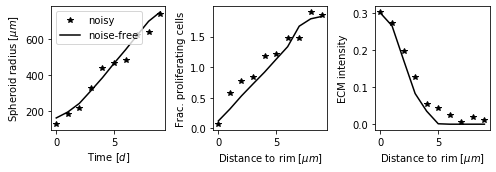

In [2]:
import pickle
import matplotlib.pyplot as plt

exact_data = pickle.load(open('exact_data_v5.dat', 'rb'))
noisy_data = pickle.load(open('noisy_data_v5.dat', 'rb'))

print(exact_data.keys())

data_ylabels = ["Spheroid radius [$\\mu m$]", "Frac. proliferating cells", "ECM intensity"]
data_xlabels = ["Time [$d$]", "Distance to rim [$\\mu m$]", "Distance to rim [$\\mu m$]"]

fig, arr_ax = plt.subplots(1,3)
for i, key in enumerate(exact_data.keys()):
    arr_ax[i].plot(noisy_data[key], '*', label='noisy', color='k')
    arr_ax[i].plot(exact_data[key], '-', label='noise-free', color='k')
    arr_ax[i].set_ylabel(data_ylabels[i])
    arr_ax[i].set_xlabel(data_xlabels[i])
arr_ax[0].legend()
fig.set_size_inches((7, 2.5))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"data.{fmt}", format=fmt)

## Plot simulated data

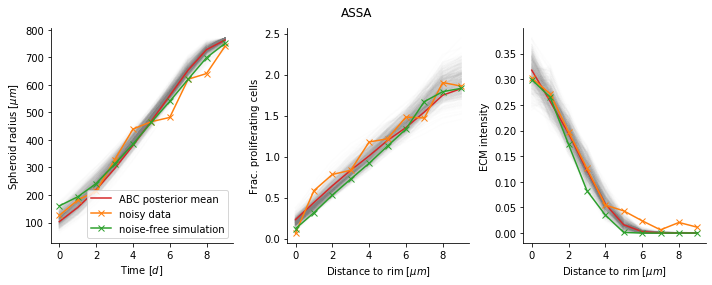

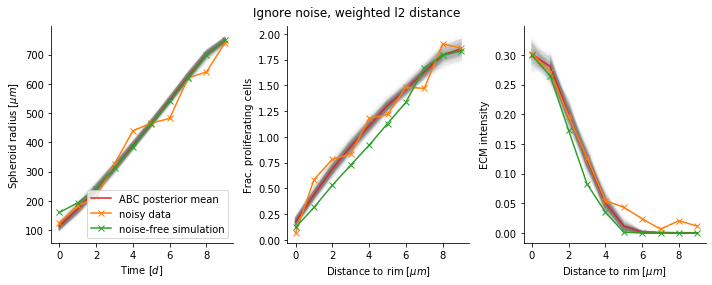

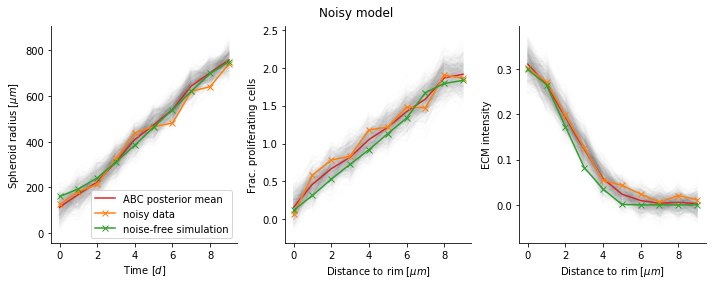

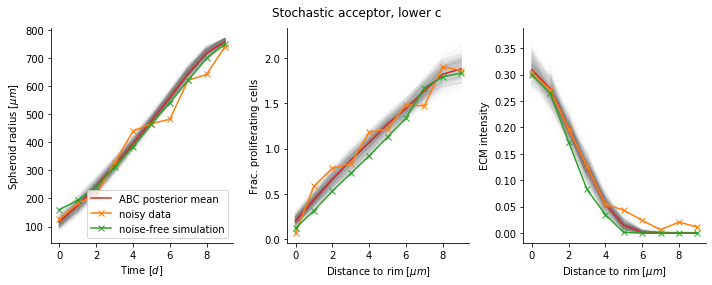

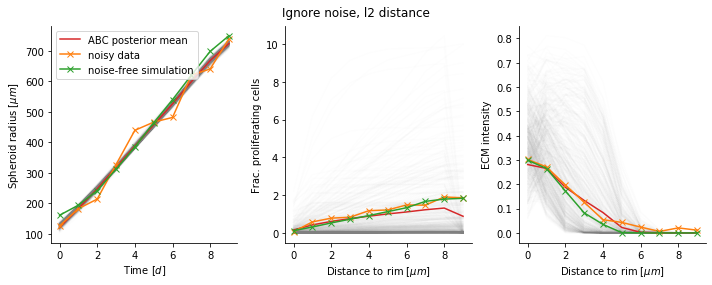

In [3]:
def plot_sum_stats(h, title, id_ = None):
    fig, arr_ax = plt.subplots(1, 3)

    def f_plot(sum_stat, weight, arr_ax, **kwargs):
        for i, key in enumerate(sum_stat.keys()):
            arr_ax[i].plot(sum_stat[key], '-', color='grey', alpha=5*1/5e2)#min(20*weight, 1))
        
    def f_plot_mean(sum_stats, weights, arr_ax, **kwargs):
        aggregated = {}
        for key in sum_stats[0].keys():
            aggregated[key] = (np.array([sum_stat[key] for sum_stat in sum_stats]) \
                               * np.array(weights).reshape((-1,1))).sum(axis=0)
        for i, key in enumerate(aggregated.keys()):
            arr_ax[i].plot(aggregated[key], '-', color='C3', alpha=1, label='ABC posterior mean')

    pyabc.visualization.plot_data_callback(h, f_plot, f_plot_mean, ax=arr_ax)

    for i, key in enumerate(noisy_data.keys()):
        arr_ax[i].plot(noisy_data[key], 'x-', color='C1', label='noisy data')
        arr_ax[i].plot(exact_data[key], 'x-', color='C2', label='noise-free simulation')
        arr_ax[i].set_ylabel(data_ylabels[i])
        arr_ax[i].set_xlabel(data_xlabels[i])
    arr_ax[0].legend()
    for ax in arr_ax:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    fig.suptitle(title)
    fig.set_size_inches((10, 4))
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    if id_:
        for fmt in ['svg', 'png']:
            plt.savefig(f"simulated_data_{id_}.{fmt}", format=fmt)
    

plot_sum_stats(h, "ASSA", 'stochacc')
plot_sum_stats(h_incorrect, "Ignore noise, weighted l2 distance", 'incorrect')
plot_sum_stats(h_noisymodel, "Noisy model", 'noisymodel')
plot_sum_stats(h_higherc, "Stochastic acceptor, lower c", 'stochacc_lowerc')
plot_sum_stats(h_incorrect_l2, "Ignore noise, l2 distance", 'incorrect_l2')

## Plot stuff

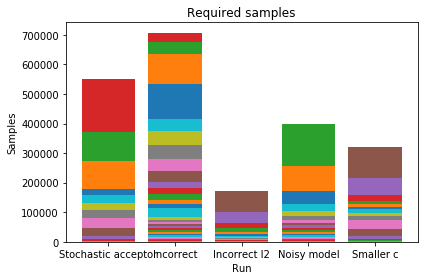

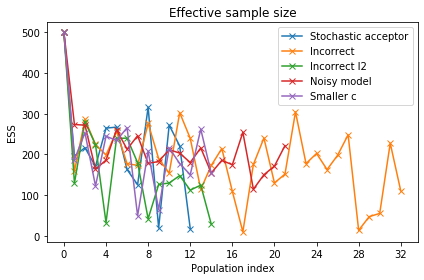

In [4]:
histories = [h, h_incorrect, h_incorrect_l2, h_noisymodel, h_higherc]
labels = ["Stochastic acceptor", "Incorrect", "Incorrect l2", "Noisy model", "Smaller c"]

pyabc.visualization.plot_sample_numbers(histories, labels)
pyabc.visualization.plot_effective_sample_sizes(histories, labels)

plt.show()

/home/yannik/pyabc/pyabc/visualization/credible.py:172: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


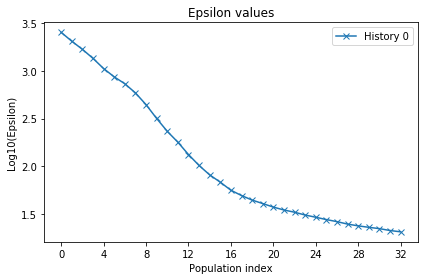

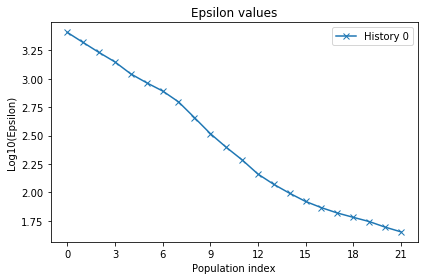

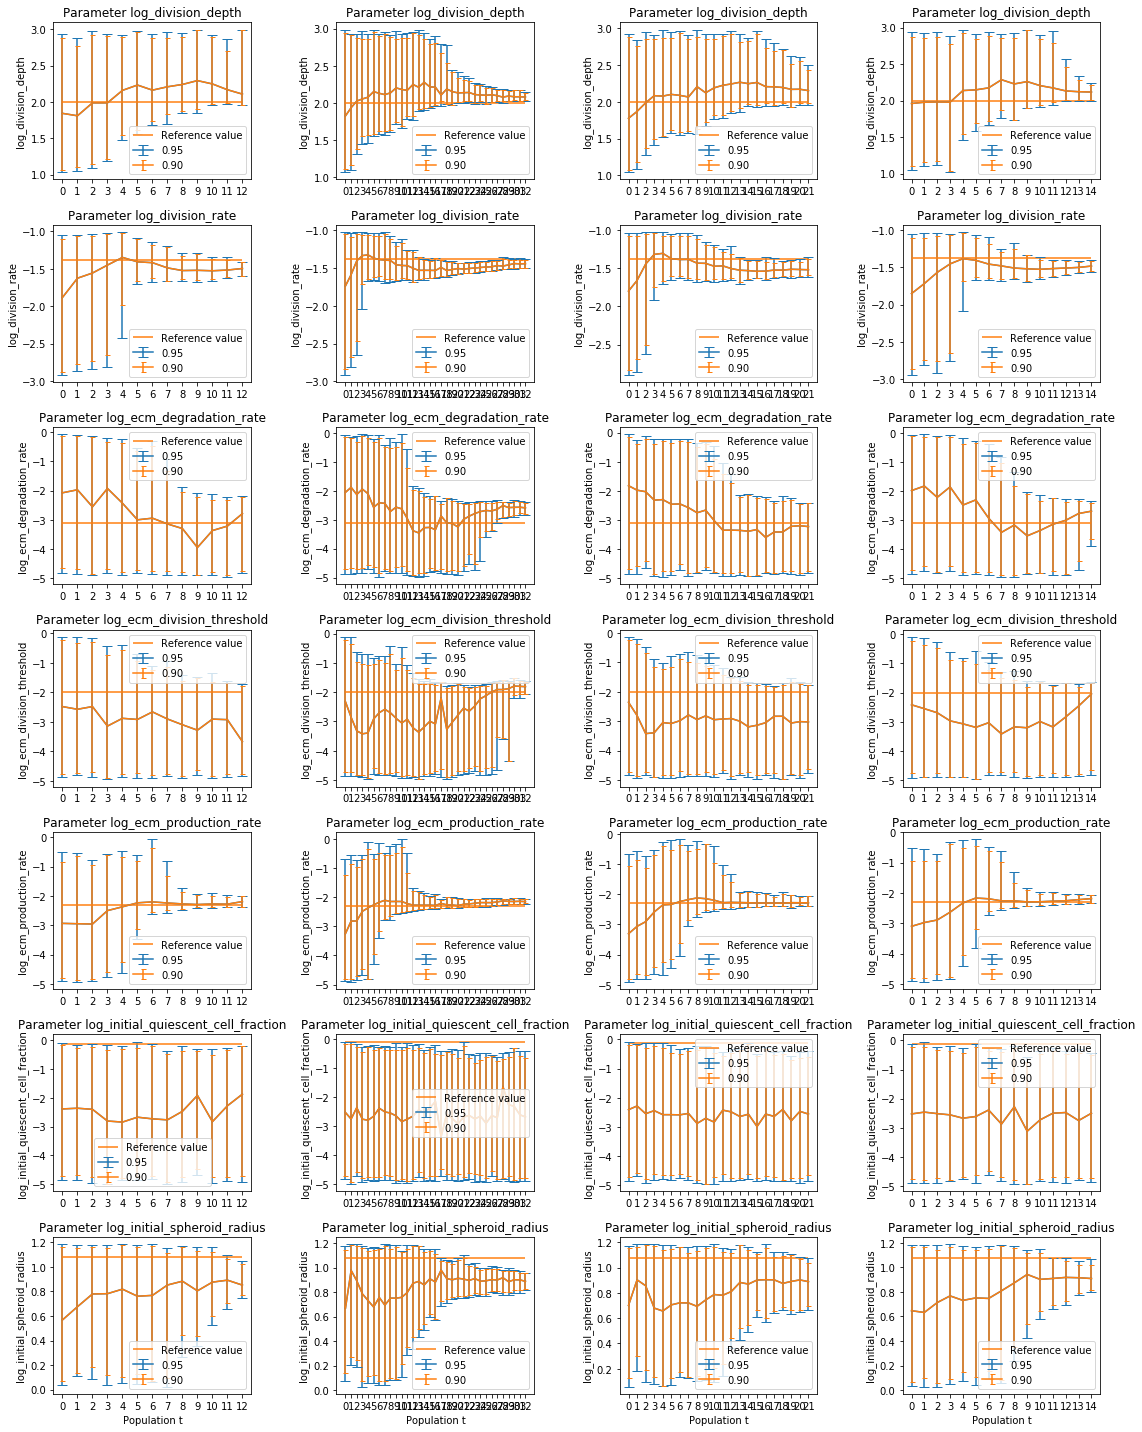

In [5]:
pyabc.visualization.plot_epsilons(h_incorrect, scale="log10")
pyabc.visualization.plot_epsilons(h_noisymodel, scale="log10")

_, arr_ax = plt.subplots(7,4)

for i, _h in enumerate([h, h_incorrect, h_noisymodel, h_higherc]):
    ax = [arr_ax[j][i] for j in range(7)]
    pyabc.visualization.plot_credible_intervals(_h, size=(5, 20), refval=refval, levels=[0.9, 0.95], arr_ax=ax)
plt.gcf().set_size_inches((16, 20))
plt.gcf().tight_layout()


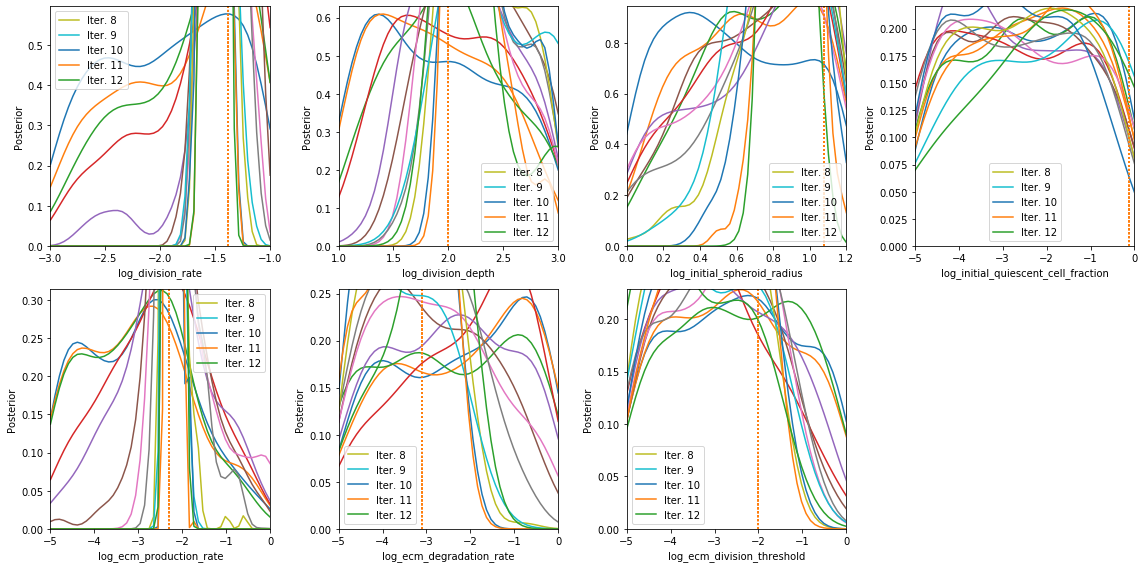

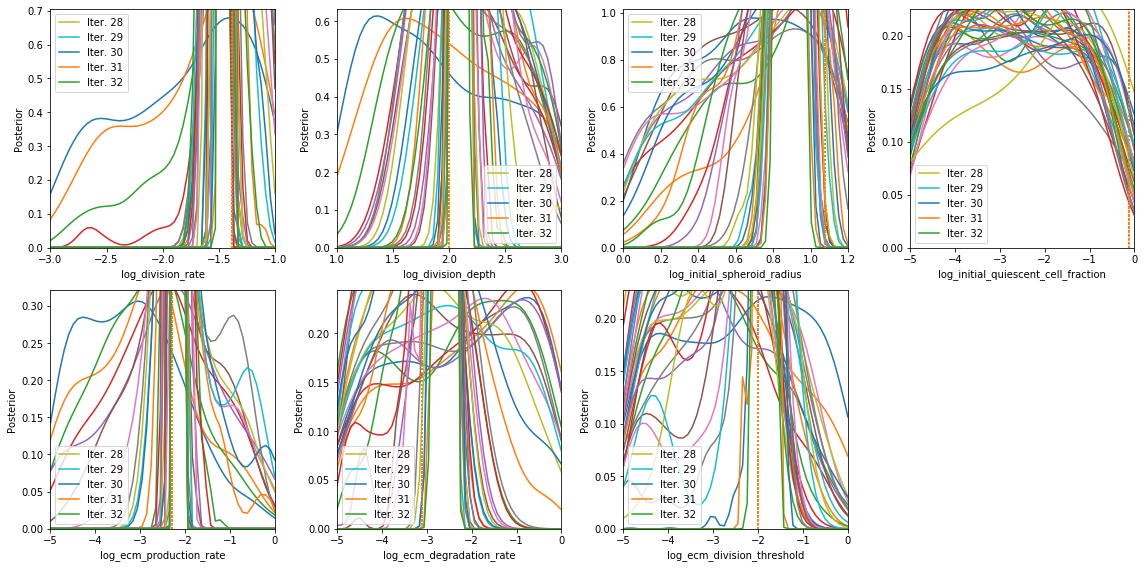

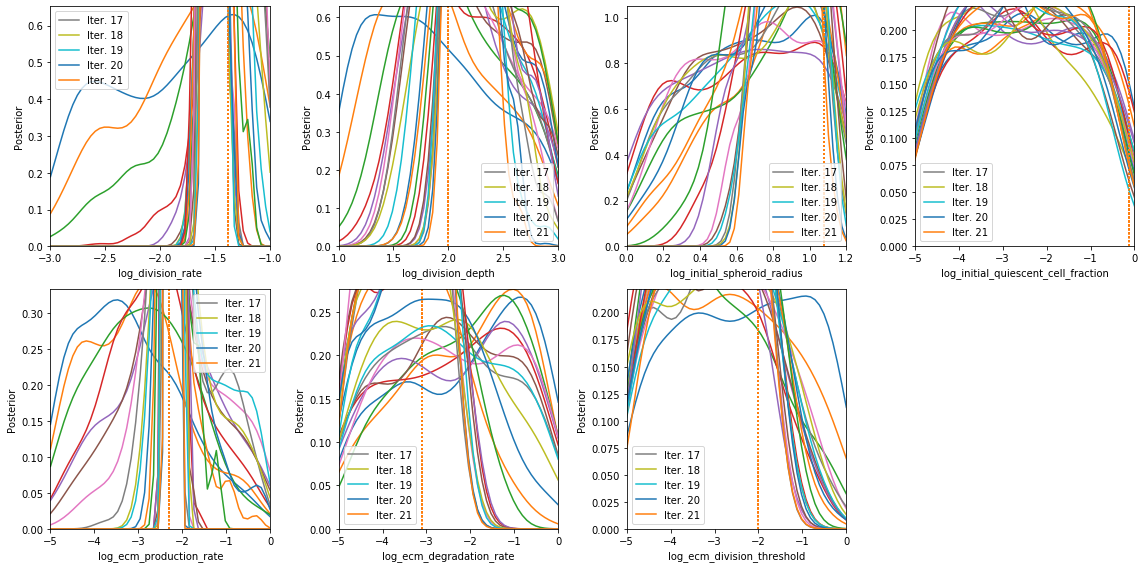

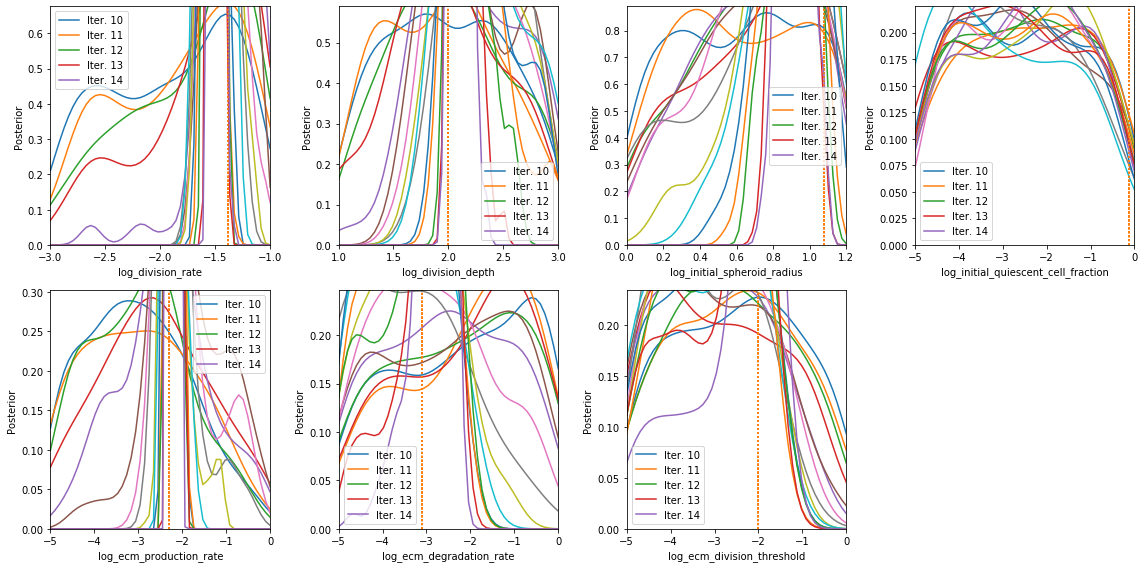

In [6]:
def plot_all(h):
    fig = plt.figure()
    for ip, p in enumerate(limits):
        ax = fig.add_subplot(2, 4, ip+1)
        for t in range(h.max_t + 1):
            pyabc.visualization.plot_kde_1d_highlevel(h, t=t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                                      ax=ax, refval=refval,
                                                      label=(f"Iter. {t}" if t > h.max_t - 5 else ""))
        ax.legend()

    fig.set_size_inches((16, 8))
    fig.tight_layout()

plot_all(h)
plot_all(h_incorrect)
plot_all(h_noisymodel)
plot_all(h_higherc)

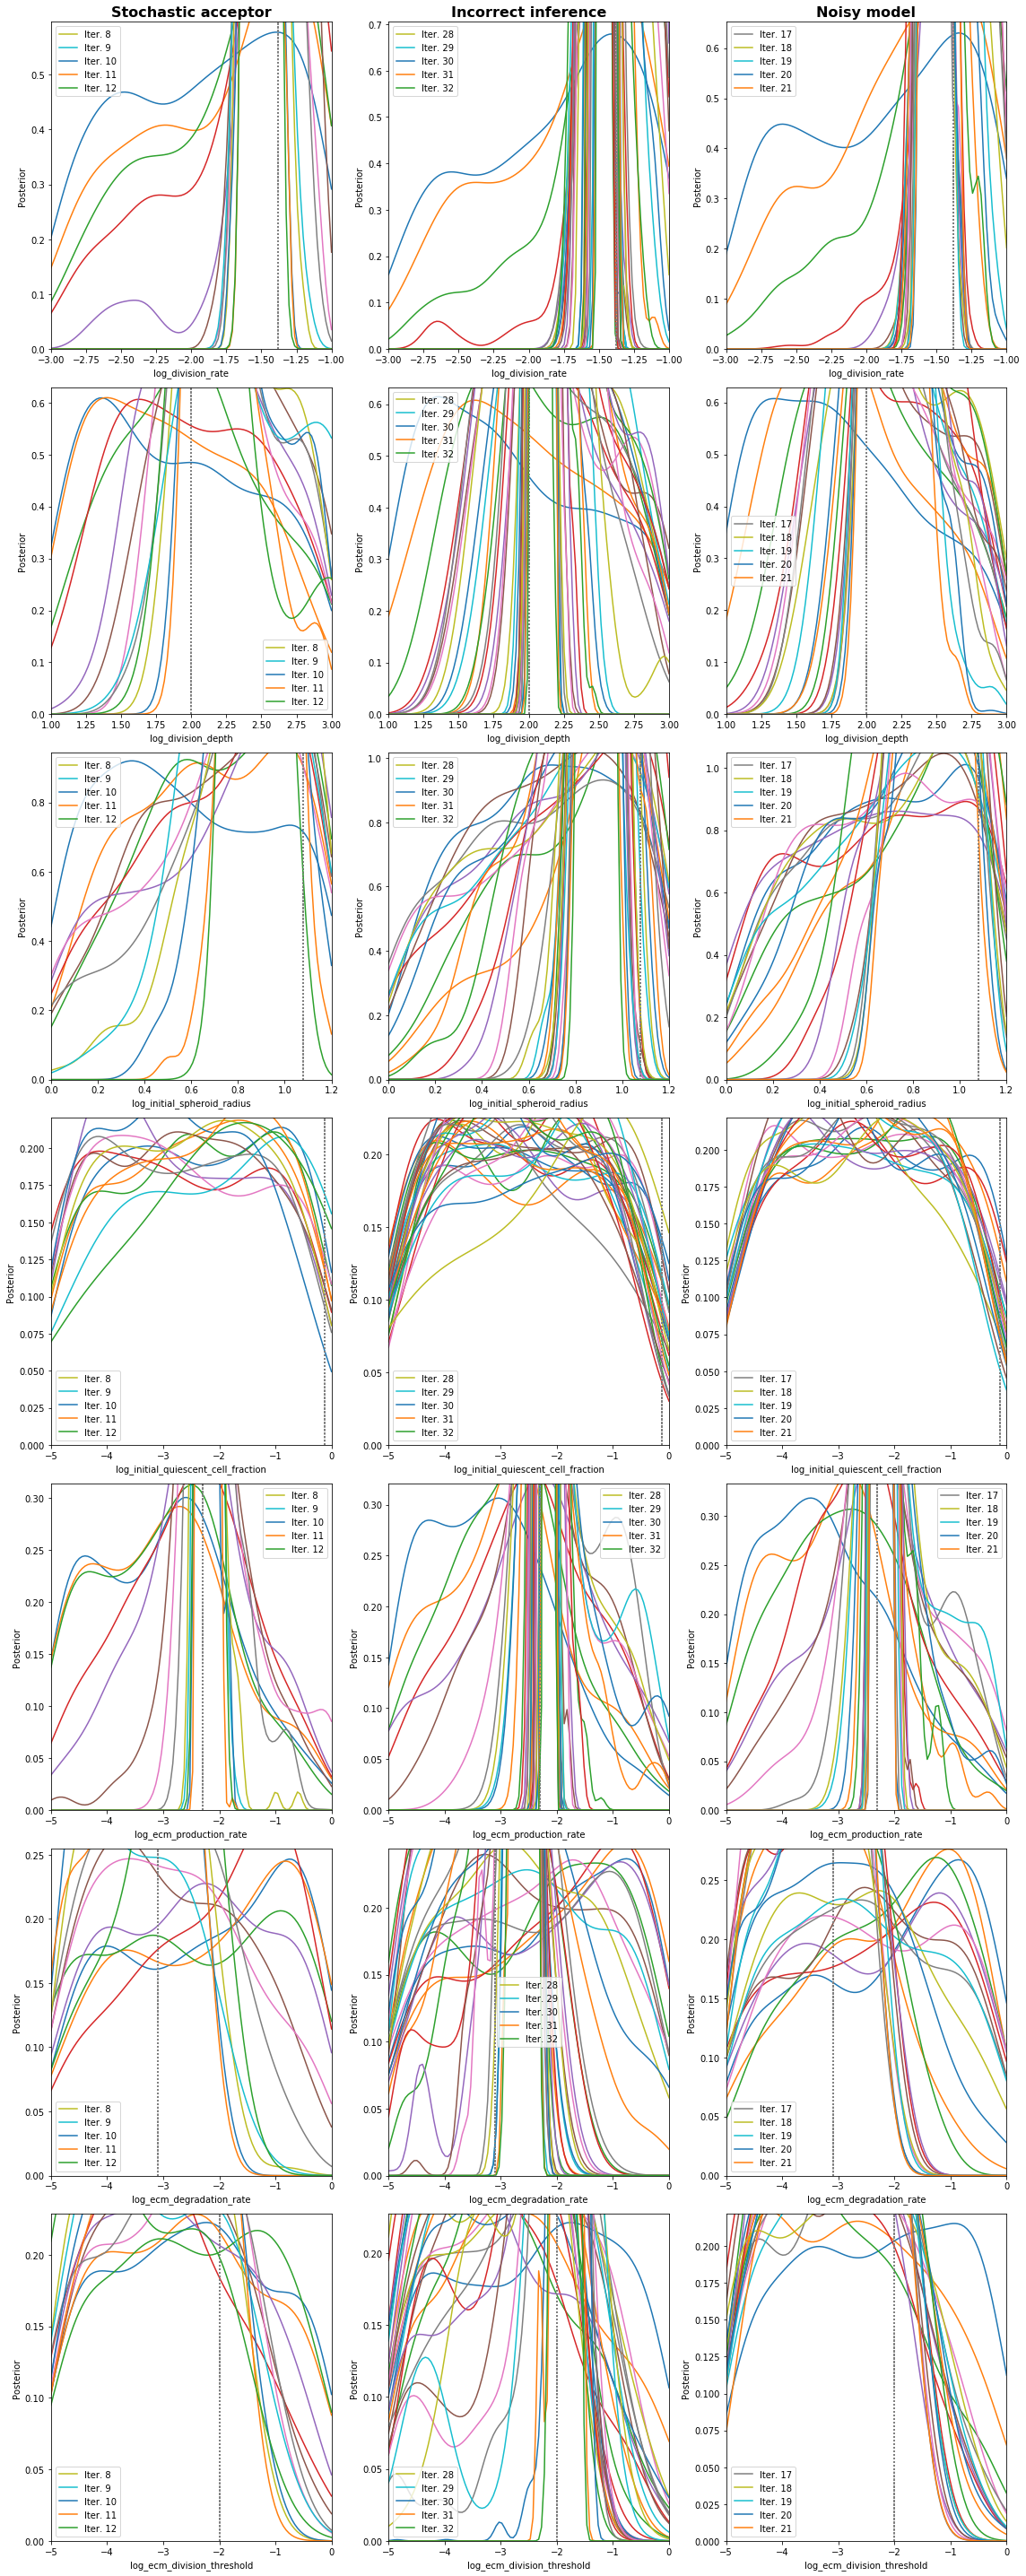

In [7]:
fig = plt.figure()

for ip, p in enumerate(limits):
    ax = fig.add_subplot(7, 3, 3*ip+1)
    for t in range(h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(h, t=t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                                  ax=ax, label=(f"Iter. {t}" if t > h.max_t - 5 else ""),
                                                  numx=100, refval=refval,refval_color='grey')
    ax.legend()
    if ip==0:
        ax.set_title("Stochastic acceptor", fontsize=16, fontweight="bold")
    ax = fig.add_subplot(7, 3, 3*ip+2)
    for t in range(h_incorrect.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(h_incorrect, t=t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                                  ax=ax, numx=100, refval=refval, refval_color='grey',
                                                  label=(f"Iter. {t}" if t > h_incorrect.max_t - 5 else ""))
    if ip==0:
        ax.set_title("Incorrect inference", fontsize=16, fontweight="bold")
    ax.legend()
    ax = fig.add_subplot(7, 3, 3*ip+3)
    for t in range(h_noisymodel.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(h_noisymodel, t=t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                                  ax=ax, numx=100, refval=refval, refval_color='grey',
                                                  label=(f"Iter. {t}" if t > h_noisymodel.max_t - 5 else ""))
    if ip==0:
        ax.set_title("Noisy model", fontsize=16, fontweight="bold")
    ax.legend()

fig.set_size_inches((16, 40))
fig.tight_layout()

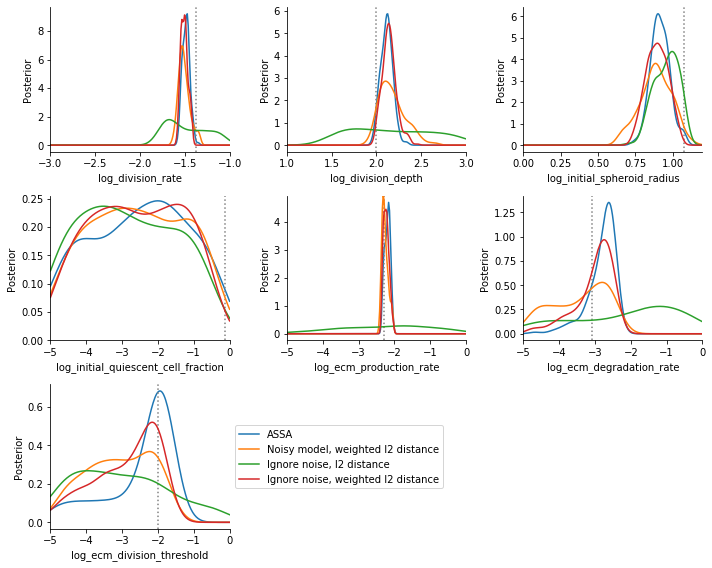

In [8]:
# only last iteration

fig = plt.figure()

for ip, p in enumerate(limits):
    ax = fig.add_subplot(3, 3, ip+1)
    #pyabc.visualization.plot_kde_1d_highlevel(h, t=h.max_t, x=p, xmin=limits[p][0], xmax=limits[p][1],
    #                                          ax=ax, label="Stochastic acceptor", refval=refval, refval_color='grey',
    #                                          numx=200)
    pyabc.visualization.plot_kde_1d_highlevel(h_higherc, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                              ax=ax, label="ASSA", refval=refval, refval_color='grey',
                                              numx=200, color='C0')
    pyabc.visualization.plot_kde_1d_highlevel(h_noisymodel, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                              ax=ax, numx=200,
                                              label="Noisy model, weighted l2 distance", color='C1')
    pyabc.visualization.plot_kde_1d_highlevel(h_incorrect_l2, t=9, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                              ax=ax, numx=200,
                                              label="Ignore noise, l2 distance", color='C2')
    pyabc.visualization.plot_kde_1d_highlevel(h_incorrect, t=22, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                              ax=ax, numx=200,
                                              label="Ignore noise, weighted l2 distance", color='C3')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.set_size_inches((10, 8))
#fig.set_size_inches((16,12))
fig.tight_layout()

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for fmt in ['svg', 'eps']:
    plt.savefig(f"tumor_final_comparison.{fmt}", format=fmt)

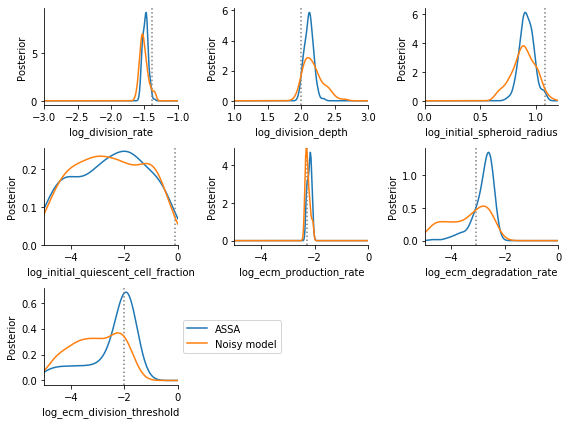

In [9]:
# only last iteration

fig = plt.figure()

for ip, p in enumerate(limits):
    ax = fig.add_subplot(3, 3, ip+1)
    #pyabc.visualization.plot_kde_1d_highlevel(h, t=h.max_t, x=p, xmin=limits[p][0], xmax=limits[p][1],
    #                                          ax=ax, label="Stochastic acceptor", refval=refval, refval_color='grey',
    #                                          numx=200)
    pyabc.visualization.plot_kde_1d_highlevel(h_higherc, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                              ax=ax, label="ASSA", refval=refval, refval_color='grey',
                                              numx=200, color='C0')
    pyabc.visualization.plot_kde_1d_highlevel(h_noisymodel, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                              ax=ax, numx=200,
                                              label="Noisy model", color='C1')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.set_size_inches((8, 6))
#fig.set_size_inches((16,12))
fig.tight_layout()

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for fmt in ['svg', 'eps']:
    plt.savefig(f"tumor_final_comparison_noisymodel_vs_stochacc.{fmt}", format=fmt)

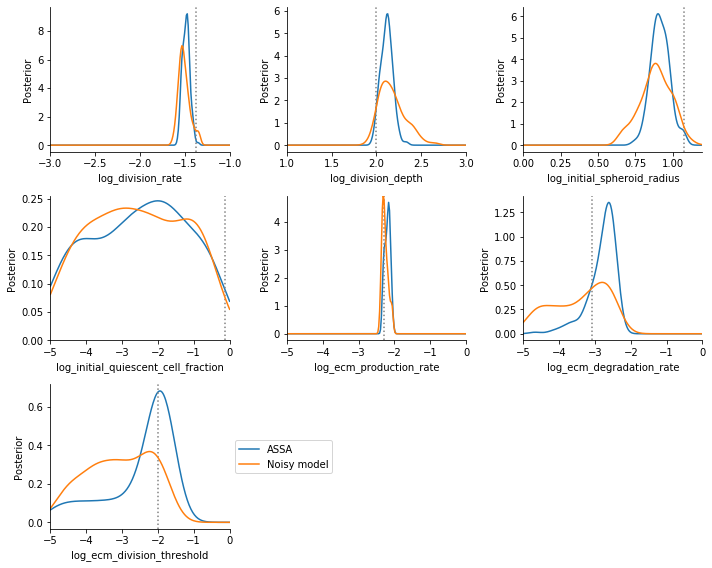

In [10]:
# only last iteration

fig = plt.figure()

for ip, p in enumerate(limits):
    ax = fig.add_subplot(3, 3, ip+1)
    #pyabc.visualization.plot_kde_1d_highlevel(h, t=h.max_t, x=p, xmin=limits[p][0], xmax=limits[p][1],
    #                                          ax=ax, label="Stochastic acceptor", refval=refval, refval_color='grey',
    #                                          numx=200)
    pyabc.visualization.plot_kde_1d_highlevel(h_higherc, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                              ax=ax, label="ASSA", refval=refval, refval_color='grey',
                                              numx=200, color='C0')
    pyabc.visualization.plot_kde_1d_highlevel(h_noisymodel, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                              ax=ax, numx=200,
                                              label="Noisy model", color='C1')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.set_size_inches((10, 8))
#fig.set_size_inches((16,12))
fig.tight_layout()

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for fmt in ['svg', 'eps']:
    plt.savefig(f"tumor_final_comparison_noisymodel_vs_stochacc_big.{fmt}", format=fmt)

In [3]:
for _h in [h, h_noisymodel, h_higherc]:
    print("ESS:", pyabc.weighted_statistics.effective_sample_size(_h.get_distribution()[1]),
          "Samples:", sum(_h.get_all_populations()['samples']))

ESS: 17.457351905991185 Samples: 550483
ESS: 221.5342745328211 Samples: 399047
ESS: 153.4188102604325 Samples: 319692


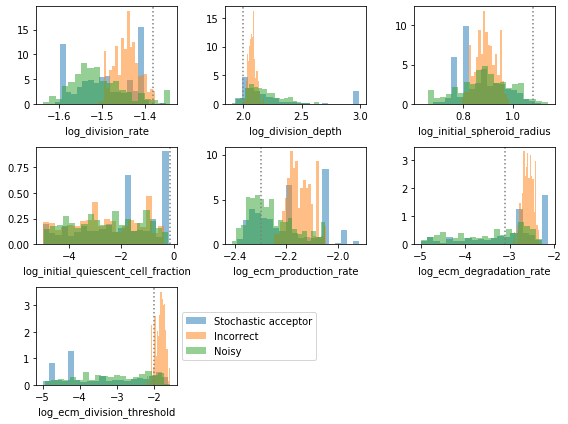

In [12]:
# only last iteration

fig = plt.figure()

for ip, p in enumerate(limits):
    ax = fig.add_subplot(3, 3, ip+1)
    pyabc.visualization.plot_histogram_1d(h, t=h.max_t, x=p, #xmin=limits[p][0], xmax=limits[p][1],
                                          ax=ax, label="Stochastic acceptor", refval=refval, refval_color='grey',
                                          bins=20, alpha=0.5)
    pyabc.visualization.plot_histogram_1d(h_incorrect, t=h_incorrect.max_t, x=p, #xmin=limits[p][0], xmax=limits[p][1],
                                          ax=ax, bins=20, alpha=0.5,
                                          label="Incorrect")
    pyabc.visualization.plot_histogram_1d(h_noisymodel, t=h_noisymodel.max_t, x=p, #xmin=limits[p][0], xmax=limits[p][1],
                                          ax=ax, bins=20, alpha=0.5,
                                          label="Noisy")
    
fig.set_size_inches((8, 6))
fig.tight_layout()

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("final_comparison.svg", format='svg')

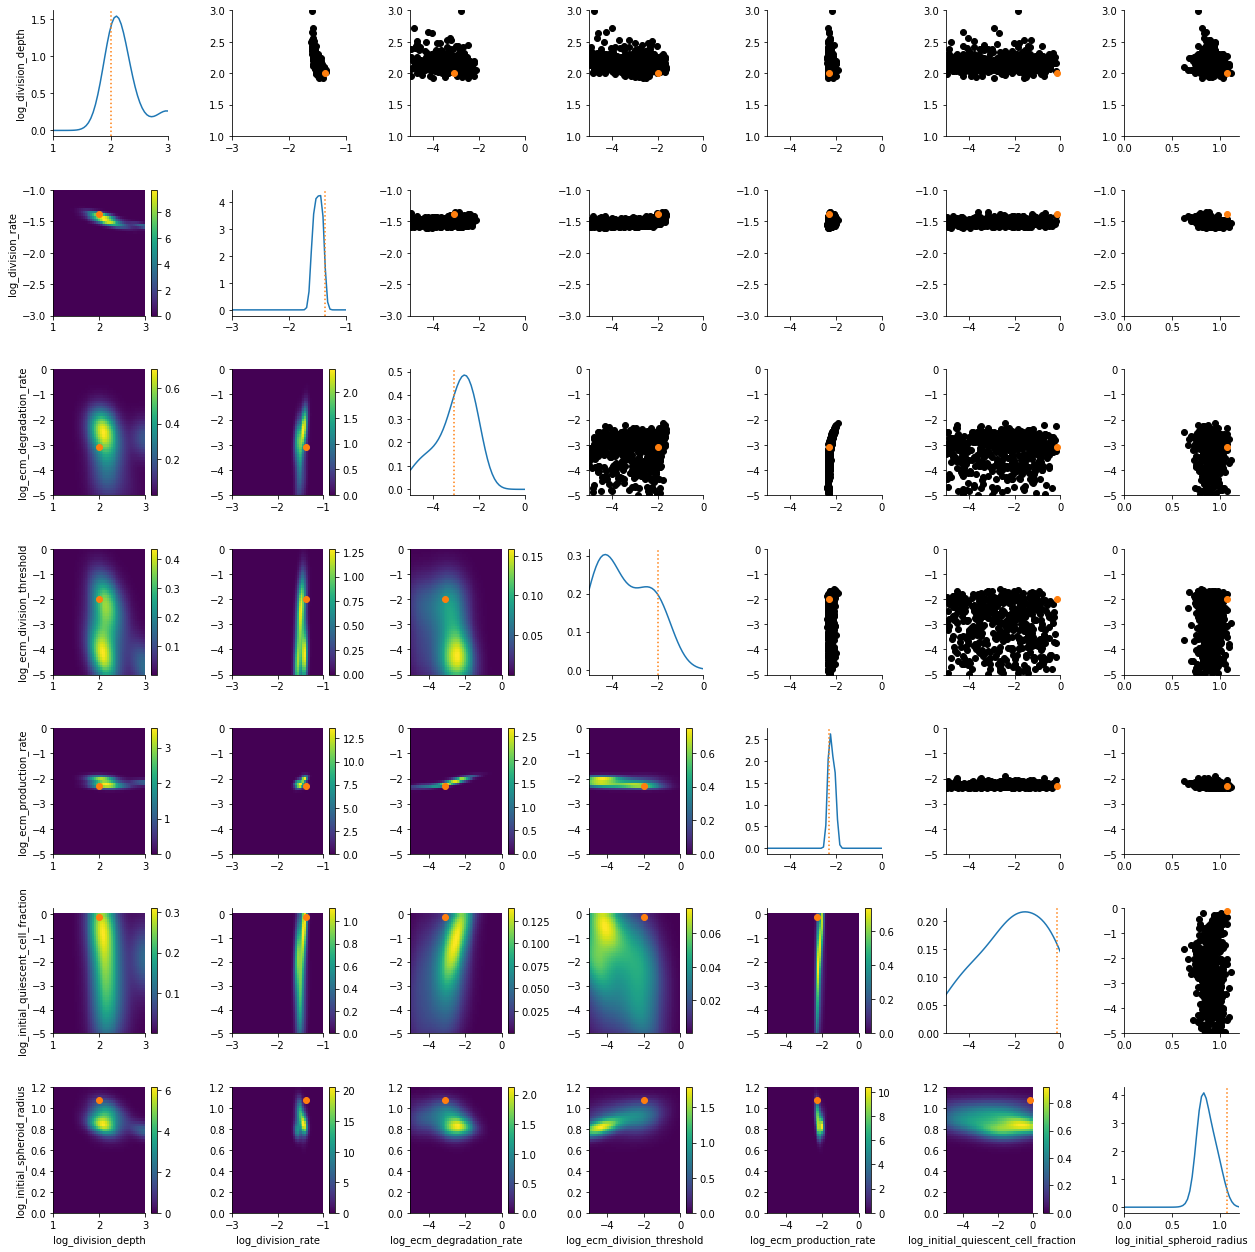

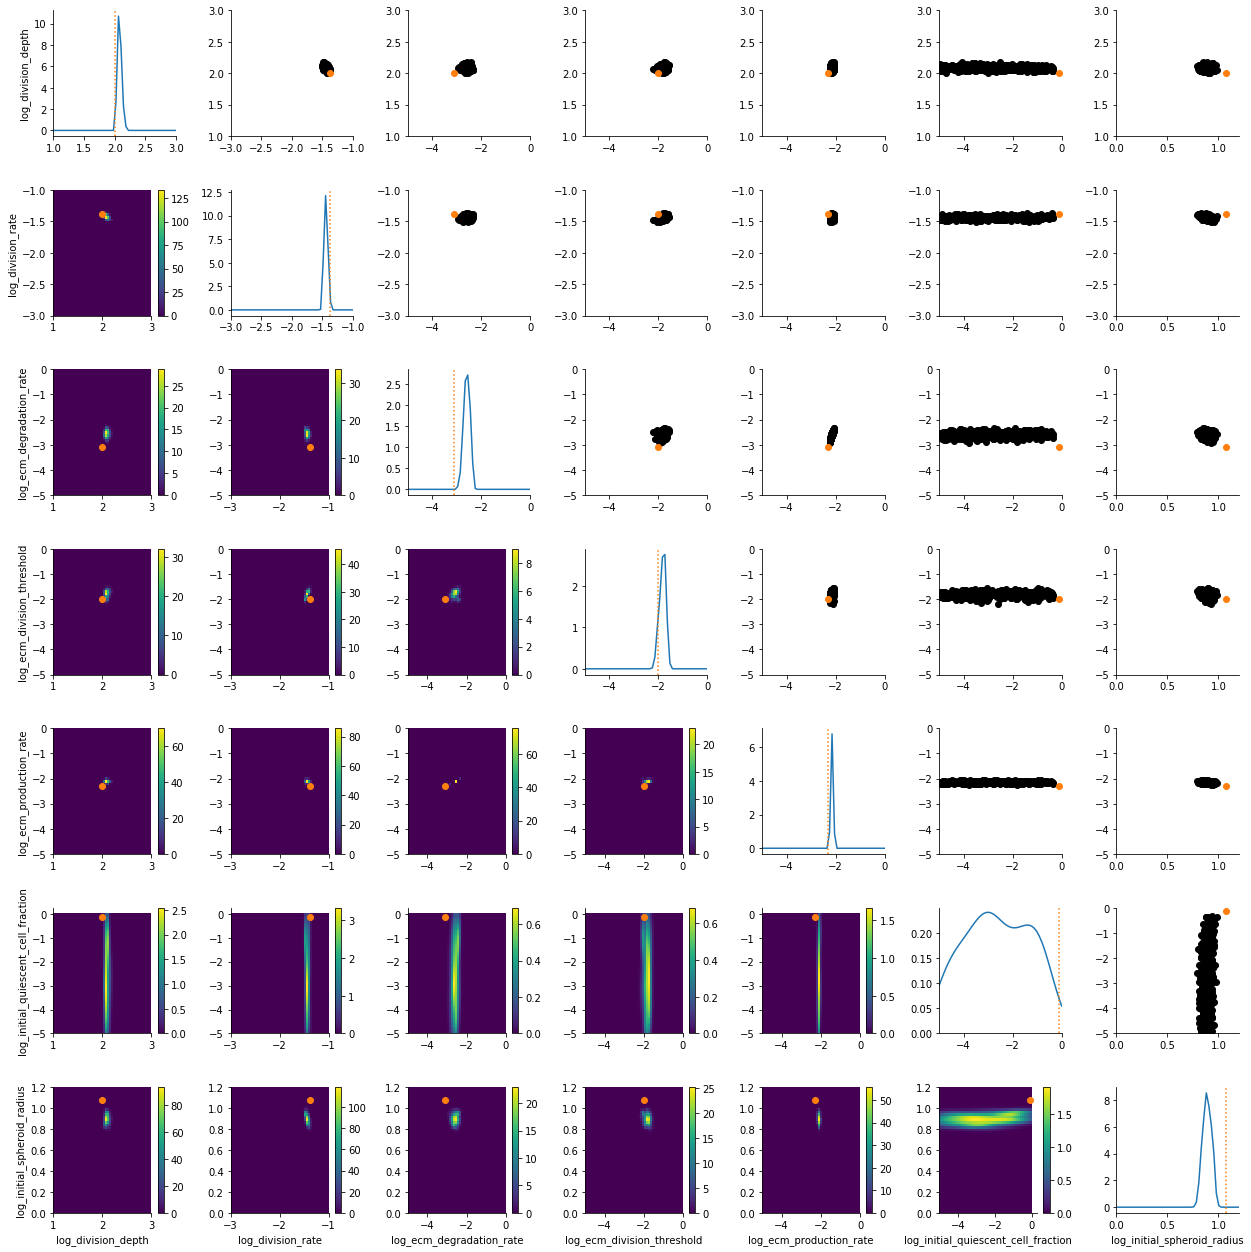

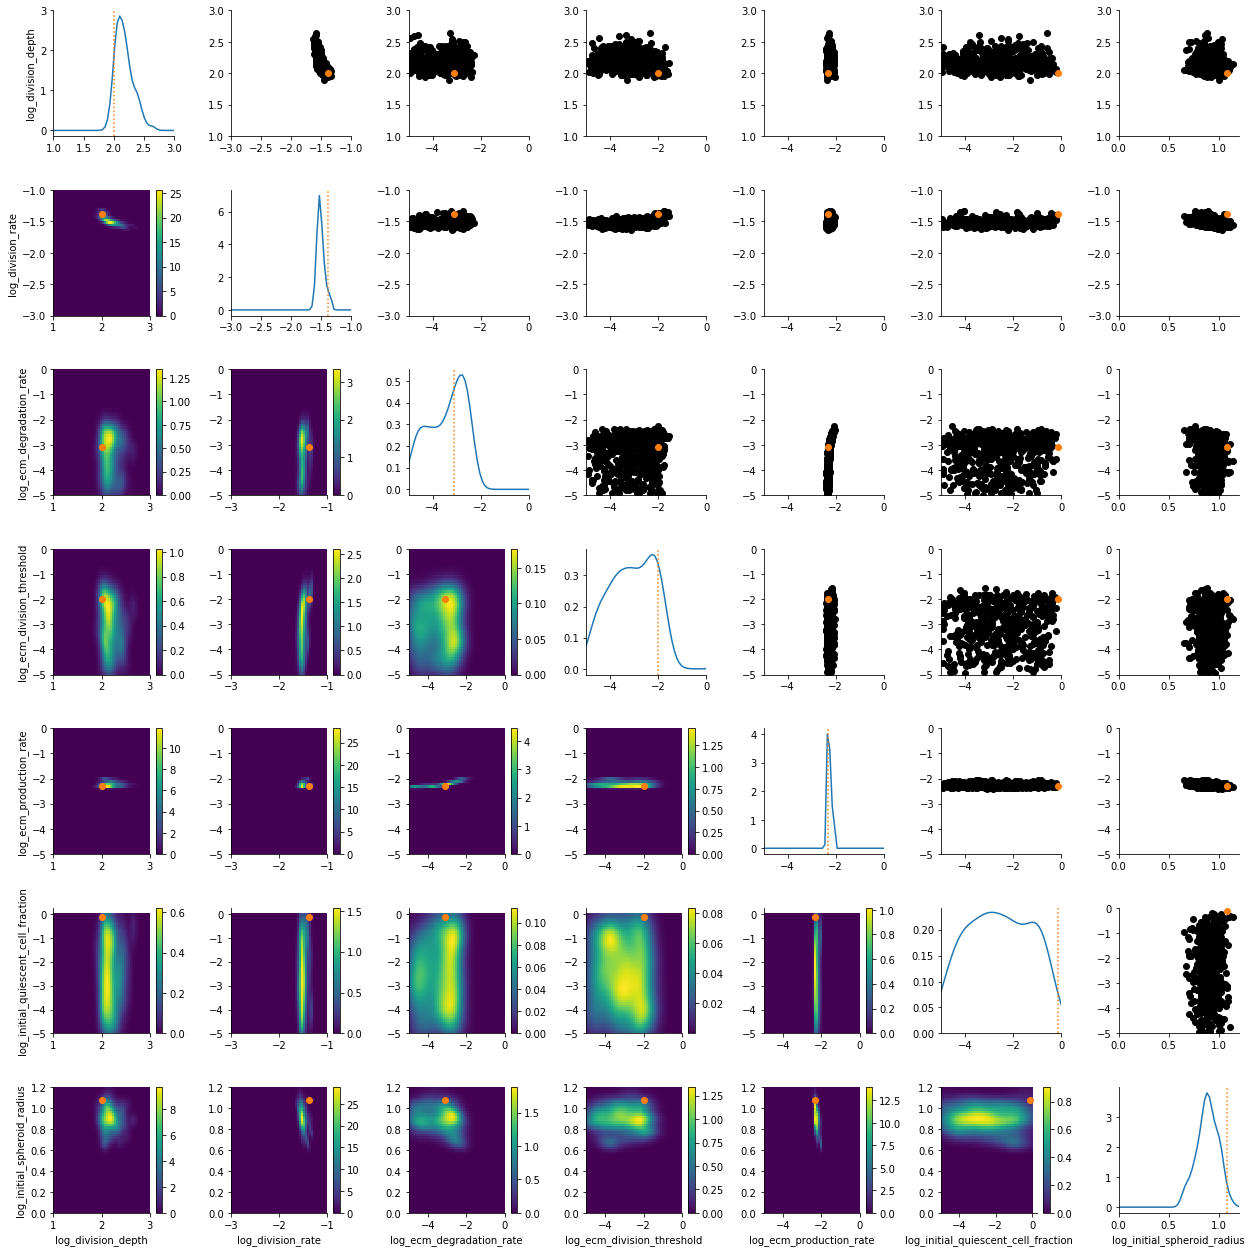

In [13]:
for _h in [h, h_incorrect, h_noisymodel]:
    pyabc.visualization.plot_kde_matrix_highlevel(_h, refval=refval, limits=limits)
plt.show()